In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import tensorflow_probability as tfp

from model import VAE

In [2]:
demo_image_dir = 'demo3'
demo_images = os.listdir(demo_image_dir)[:4]
demo_images = [os.path.join(demo_image_dir, image) for image in demo_images]
print(demo_images)

['demo3\\16556.png', 'demo3\\16557.png', 'demo3\\16558.png', 'demo3\\16559.png']


In [3]:
def image_to_tensor(image):
    array = np.array(image)
    tensor = tf.convert_to_tensor(array, dtype=tf.float32)
    tensor = tf.expand_dims(tensor, axis=0)
    return tensor/255

In [4]:
demo_image_tensors =[]
for image in demo_images:
    img = PIL.Image.open(image)
    tensor = image_to_tensor(img)
    demo_image_tensors.append(tensor)

In [5]:
latent_dim = 1024
kl_factor = 10.0

model = VAE(latent_dim)
model_id = f'dim_{model.latent_dim}_kl_{int(kl_factor)}'

output_dir = 'output'
checkpoint_path = os.path.join(output_dir, 'checkpoints', model_id)
log_dir = os.path.join(output_dir, 'logs', model_id)
images_save_dir = os.path.join(output_dir, 'images', model_id)

In [6]:
ckpt = tf.train.Checkpoint(model=model)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
ckpt.restore(ckpt_manager.latest_checkpoint)

In [7]:
def show_original_images(images):
    fig = plt.figure(figsize=(7, 7))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i][0])
    plt.savefig(os.path.join(images_save_dir, 'original.png'))
    plt.show()
    # plt.close()

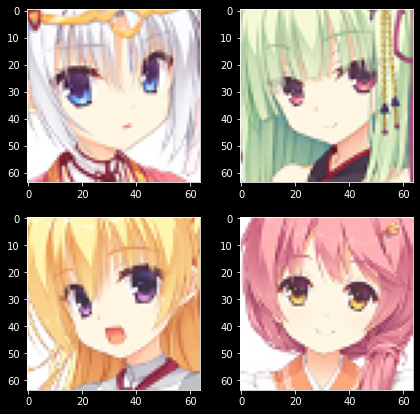

In [8]:
show_original_images(demo_image_tensors)

In [9]:
demo_image_latent = [model.compute_latent(*model.encode(x)) for x in demo_image_tensors]

In [10]:
def show_reconstructed_image(model):
    fig = plt.figure(figsize=(7, 7))
    for i in range(4):
        image = model.decode(demo_image_latent[i], apply_sigmoid=True)
        plt.subplot(2, 2, i+1)
        plt.imshow(image[0])
    plt.savefig(os.path.join(images_save_dir, 'reconstructed.png'))
    plt.show()

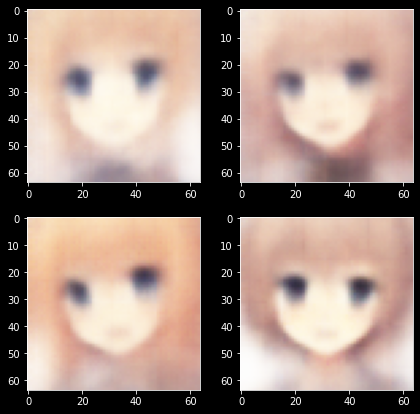

In [11]:
show_reconstructed_image(model)

In [12]:
def plot_latent_images(model, n):
    grid_x = np.linspace(1, 0, n)
    grid_y = np.linspace(1, 0, n)

    latents = []

    fig = plt.figure(figsize=(10, 10))
    for j in range(n):
        for i in range(n):
            latent = demo_image_latent[0] * grid_x[i] * grid_y[j]+\
                    demo_image_latent[1] * (1-grid_x[i]) * grid_y[j]+\
                    demo_image_latent[2] * grid_x[i] *(1-grid_x[j])+\
                    demo_image_latent[3] * (1-grid_x[i]) *(1-grid_x[j])

            latents.append(latent)

    latents = tf.concat(latents, axis=0)
    images = model.decode(latents, apply_sigmoid=True)

    for i, image in enumerate(images):
            plt.subplot(n, n, i+1)
            plt.axis('off')
            plt.imshow(image)
    plt.savefig(os.path.join(images_save_dir, 'interpolation.png'))
    plt.show()

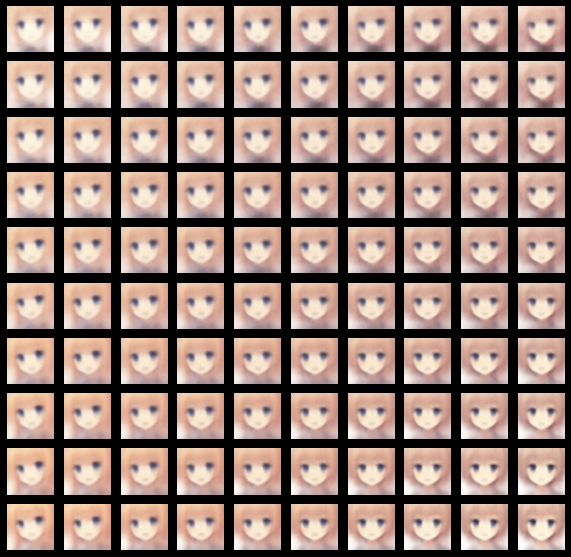

In [13]:
plot_latent_images(model, 10)